# 📚  Exercise Session - Week 2

Welcome to Week 2 exercise's session of CS552-Modern NLP!


> **What will be covered:**
1. [**TASK A:** N-gram Language Models](#ngram_lm)
    - [Unigram Language Model](#unigram_lm)
    - [Bi-gram Language Model](#bigram_lm)
    - [Tri-gram Language Model](#trigram_lm)
     
2. [**TASK B:** Neural Language Models](#neural_lm)
    - [Fixed-Window Neural Language Model](#fixed_window_lm)
    - [RNN-based Language Model](#rnn_lm)

> **By the end of the session you will be able to:**
> - ✅  Compute and interpret the perplexity of a language model 
> - ✅  Implement N-gram language models for N=1,2,3
> - ✅  Implement, train, and evaluate a fixed window language model
> - ✅  Evaluate an RNN language model
> - ✅  Understand the advantages and disadvantages of each of the above models

In [ ]:
# install the libraries if needed.
# !pip install datasets
# !pip install numpy

<a name="ngram_lm"></a>
## 1. Task A: N-gram Language Models 


In this exercise, we will better understand the functioning of different types of (non-neural) language modeling, namely,  Unigram LM, Bi-gram LM, and Tri-gram LM.

### 1.1 Unigram Language Model <a name="unigram_lm"></a>
In the simple Unigram language model, we pick/generate next token independent of the previous token. In other words, during the generation, we pick the tokens according to the token probability. Therefore, for an arbitrary sequence $x_1x_2~...x_n$, its respective probability becomes:
$$p(x_1x_2~...x_n) = \Pi_{i=1} ^n p(x_i)$$
Let's use an unsupervised dataset (raw corpus) to evaluate this model's perplexity. We use Huggingface's `datasets` library to download needed datasets.
 

Here we use the `Penn Treebank` dataset, featuring a million words of 1989 Wall Street Journal material. The rare words in this version are already replaced with `<unk>` token. The numbers are also replaced with a special token. This token replacement helps us to end up with a more reasonable vocabulary size to work with.


In [1]:
import datasets
import numpy as np
import torch
from datasets import load_dataset

ptb_dataset = load_dataset("ptb_text_only", split="train")

# splitting dataset in train/test (to be later used for language model evaluation)
ptb_dataset = ptb_dataset.train_test_split(test_size=0.2, seed=1)
ptb_train, ptb_test = ptb_dataset['train'], ptb_dataset['test']

Generating train split:   0%|          | 0/42068 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3761 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3370 [00:00<?, ? examples/s]

#### Let's have a look at a few samples of the training dataset (and also the structure of the dataset)

In [2]:
print(f"{ptb_train[0]}\n\n{ptb_train[1]}\n\n{ptb_train[2]}")

{'sentence': "a former executive agreed that the departures do n't reflect major problems adding if you see any company that grows as fast as reebok did it is going to have people coming and going"}

{'sentence': 'with talk today of a second economic <unk> in west germany east germany no longer can content itself with being the economic star in a loser league'}

{'sentence': 'transportation secretary sam skinner who earlier fueled the anti-takeover fires with his <unk> attacks on foreign investment in u.s. carriers now says the bill would further <unk> the jittery capital markets'}


During generation with a given language model, we often need to have a `<stop>` token in our vocabulary to terminate the generation of a given sentence/paragraph. In this dataset, every sample is a sentence, and the `<stop>` token should be added to the end of every sample (i.e., end of sentence).

#### Create a new train/test dataset starting from `ptb_train` and `ptb_test` that has a `<stop>` at the end of each sentence. (Note: do not change the structure of the datasets objects, and just change the respective sentences as discussed).
Hint: use the `.map()` functionality of the `datasets` package (read more [here](https://huggingface.co/docs/datasets/process#map])).

In [7]:
def add_stop_token(input_sample: dict):
    """
    args:
        input_sample: a dict representing a sample of the dataset. (look above for the dict struture)
    output:
        modified_sample: modified dict adding <stop> at the end of each sentence.
    """
    # YOUR CODE HERE

    return {'sentence': input_sample["sentence"] + " <stop>"}


ptb_train = ptb_train.map(add_stop_token)
ptb_test = ptb_test.map(add_stop_token)

Map:   0%|          | 0/33654 [00:00<?, ? examples/s]

Map:   0%|          | 0/8414 [00:00<?, ? examples/s]

In [9]:
print(f"{ptb_train[0]}\n\n{ptb_train[1]}\n\n{ptb_train[2]}")

{'sentence': "a former executive agreed that the departures do n't reflect major problems adding if you see any company that grows as fast as reebok did it is going to have people coming and going <stop>"}

{'sentence': 'with talk today of a second economic <unk> in west germany east germany no longer can content itself with being the economic star in a loser league <stop>'}

{'sentence': 'transportation secretary sam skinner who earlier fueled the anti-takeover fires with his <unk> attacks on foreign investment in u.s. carriers now says the bill would further <unk> the jittery capital markets <stop>'}


For both `ptb_train` and `ptb_test` datasets, filter out every sample that has less than 3 tokens. it will help remove very short sentences that are not very helpful for training/evaluating a langugage model.

Hint: use `.filter()` functionality of the `datasets` package (read more [here](https://huggingface.co/docs/datasets/process#select-and-filter)).

In [16]:
num_tokens_filter = lambda input_sample: len(input_sample['sentence'].split(" ")) > 3

ptb_train = ptb_train.filter(num_tokens_filter)
ptb_test = ptb_test.filter(num_tokens_filter)

Filter:   0%|          | 0/33654 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8414 [00:00<?, ? examples/s]

#### What are the 10 most frequent tokens in this dataset? Can you spot the token used to replace the numbers in this dataset? How are rare tokens replaced in this dataset?

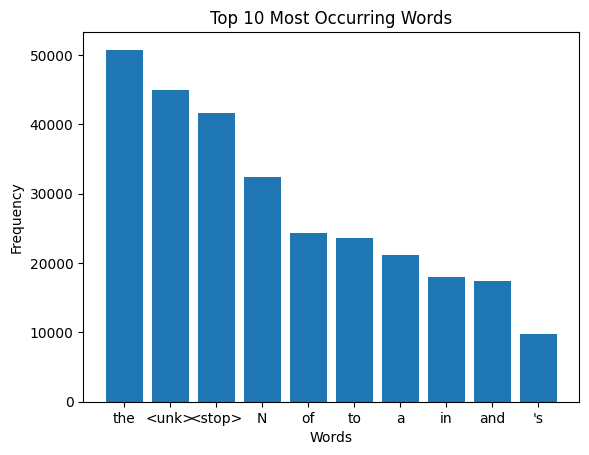

In [26]:
from matplotlib import pyplot as plt
from collections import Counter

# Flatten the list of tokenized sentences and count word occurrences
train_word_counts = Counter(word for input_sample in ptb_train for word in input_sample['sentence'].split(" "))
test_word_counts = Counter(word for input_sample in ptb_test for word in input_sample['sentence'].split(" "))

# Step 4 & 5: Find the top 10 most common words
most_common_words = (train_word_counts + test_word_counts).most_common(10)

# Step 6: Plot the histogram
words, frequencies = zip(*most_common_words)
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Occurring Words')
plt.show()

#### Now let's create a dictionary of the word probabilites (in the format of `{word: Prob(word)}`in the following function. We will use these probabilities to estimate sequence probabilities for a given sequence, as mentioned above.

In [34]:
from collections import defaultdict


def get_word_probability_dict(train_dataset: datasets.arrow_dataset.Dataset):
    """
    args: 
        train_dataset: a Dataset object that can be iterated to get all the sentences
    output:
        word_prob_dict: a dictionary containing the word probabilities (and outputting zero for non-seen tokens)
    """
    word_counts = Counter(word for input_sample in train_dataset for word in input_sample['sentence'].split(" "))

    counts = np.array(list(word_counts.values()))
    words = np.array(list(word_counts.keys()))

    total_count = counts.sum()

    probabilities = counts / total_count

    word_prob_dict = defaultdict(float, zip(words, probabilities))

    return word_prob_dict


word_prob_dict = get_word_probability_dict(ptb_train)

Let's also get a sense of how high the top-k probabilities are:

In [35]:
sorted(word_prob_dict.items(), key=lambda item: item[1], reverse=True)[:20]

[('the', 0.05472703188187844),
 ('<unk>', 0.0482614478434353),
 ('<stop>', 0.044881771985074446),
 ('N', 0.03495565859883598),
 ('of', 0.026222134181755948),
 ('to', 0.02546345893922917),
 ('a', 0.022772385299218552),
 ('in', 0.01950186165159423),
 ('and', 0.01888333245742053),
 ("'s", 0.010578331534343193),
 ('for', 0.009578443381670245),
 ('that', 0.009567662916412315),
 ('$', 0.008023361268213933),
 ('is', 0.007981586965339457),
 ('it', 0.006557217993135539),
 ('said', 0.006522181481047268),
 ('on', 0.006054578800484582),
 ('at', 0.005317464488473661),
 ('by', 0.005308031581372973),
 ('as', 0.00520157448695092)]

#### Now let's analyze the Unigram language model for different sequences. We first create a function that can output the probability for a given string.

In [36]:
def unigram_lm_seq_probability(input_sentence: str,
                               word_prob_dict: dict):
    """
    args:
        input_sentence: The input sequence string. Here we assume
        word_prob_dict: A dictionary containing the probability for a given token
    output:
        probability: The probability of the input_sentence according to the Unigram language model
    """
    probability_map_fn = np.vectorize(lambda word_key: word_prob_dict[word_key])
    word_probs = probability_map_fn(np.array(input_sentence.split(" ")))

    return np.prod(word_probs)

#### Let's investigate a major issue with Unigram language model. What are the probabilities for the two following sequences?
- the the the the \<stop>
- i love computer science \<stop>

DIscussion: How can we avoid having large probability values for sequences like `the the the <stop>`

In [37]:
seq1 = "the the the the <stop>"
seq2 = "i love computer science <stop>"

prob_seq1 = unigram_lm_seq_probability(seq1, word_prob_dict)
prob_seq2 = unigram_lm_seq_probability(seq2, word_prob_dict)
print(f"probability for seq1 is {prob_seq1}, and for seq2 is {prob_seq2}")

probability for seq1 is 4.0260352626148156e-07, and for seq2 is 2.3386075741772593e-17


#### Now let's formally evaluate the Unigram model in terms of perplexity. We first compute the entropy as the average negative log-likelihood:
$$H(W_{test}∣M)= \frac{1}{|W_{test}|} \sum_{w\in W_{test}} −log_2P(w∣M)$$
, where $W_{test}$ is the input sequence and M is the Unigram language model. (note that the logarithm is in base 2).

In order to get a reliable value, we will do the above calculation for all the sentences in `ptb_test` dataset and then an average is taken over all these samples.

In [52]:
def get_unigram_lm_entropy(input_sentence: str,
                           word_prob_dict: dict):
    """
    args:
        input_sentence: the input string that we would like to have its respective entropy value.
        word_prob_dict: A dictionary containing the probability for a given token
    output:
        entropy: entropy value as defined above
    """
    probability_map_fn = np.vectorize(lambda word_key: word_prob_dict[word_key])
    word_probs = probability_map_fn(np.array(input_sentence.split(" ")))

    # if np.count_nonzero(word_probs) < len(word_probs):
    #     print(list(zip(input_sentence.split(" "), word_probs)))

    return -np.log2(word_probs).mean()

Now compute the average entropy for all the sentences in the `ptb_test` given above function, and then compute the average entropy. Then compute the perplexity as $2^{\bar{H}}$, where $\bar{H}$ is the average perplexity over the test dataset.

In [61]:
def get_unigram_lm_perplexity(test_dataset: datasets.arrow_dataset.Dataset,
                              word_prob_dict: dict):
    """
    args:
        test_dataset: the test dataset samples are used to compute the perplexity for the Unigram LM.
        word_prob_dict: A dictionary containing the probability for a given token
    output:
        perplexity: entropy value as defined above
    """
    avg_entropy_per_sample = test_dataset.map(
        lambda input_sample: {'avg_entropy': get_unigram_lm_entropy(input_sample['sentence'], word_prob_dict)})
    avg_entropy = np.array(avg_entropy_per_sample["avg_entropy"])
    # Filter sentences with an infinite entropy (e.g. they contain at least one word that is not in the word_prob_dict)
    avg_entropy = avg_entropy[avg_entropy < 1E308].mean()
    return 2 ** avg_entropy


unigram_lm_perplexity = get_unigram_lm_perplexity(ptb_test, word_prob_dict)
print(f"The perplexity for the Unigram language model is {unigram_lm_perplexity}")

The perplexity for the Unigram language model is 679.8932253758302


As discussed in the lectures, the models with lower perplexities are desired; however, we should be careful when comparing language models with different vocabualry sizes.
#### In the `ptb_train` dataset, replace every token that is appearing less than 10 times with the `<unk>` token. (Note: the same token replacement should be done for the test dataset). What is the Unigram language model perplexity for the new dataset?
Discussion: What would happen to the vocabulary size and perplexity as we increase the rare token threshold to higher values? (instead of 10 here)

In [82]:
def remove_rare_token(train_dataset: datasets.arrow_dataset.Dataset,
                      test_dataset: datasets.arrow_dataset.Dataset,
                      rare_token_threshold: int):
    """
    Note that the tokens that are considered rare here, are identified based on the train_dataset, so that
    we have the same token mapping (to <unk>) for both the train and test datasets. 
    args:
        train_dataset: the input dataset where its rare tokens has to be replaced with <unk> token.
        rare_token_threshold: every word that is appearing less than this threshold in the train dataset will
                              be replace with the <unk> token
    output:
        cleaned_train_dataset: the cleaned train dataset where rare tokens are replace with <unk> token.
        cleaned_test_dataset: the cleaned test dataset where rare tokens are replace with <unk> token.
    """

    train_word_counts = Counter(word for input_sample in train_dataset for word in input_sample['sentence'].split(" "))
    keys_with_values_less_than_10 = set(
        [word for word, count in train_word_counts.items() if count < rare_token_threshold])

    def replace_word_fn(input_sample):
        return {'sentence': " ".join([word if not word in keys_with_values_less_than_10 else "<unk>" for word in
                                      input_sample['sentence'].split(" ")])}

    cleaned_train_dataset = train_dataset.map(replace_word_fn)
    cleaned_test_dataset = test_dataset.map(replace_word_fn)

    return cleaned_train_dataset, cleaned_test_dataset


cleaned_train_dataset, cleaned_test_dataset = remove_rare_token(train_dataset=ptb_train,
                                                                test_dataset=ptb_test,
                                                                rare_token_threshold=10)


##### Now, follow similar steps to compute the perplexity given the two new datasets (`cleaned_train_dataset` and `cleaned_test_dataset`)

In [83]:
cleaned_unigram_lm_perplexity = get_unigram_lm_perplexity(cleaned_test_dataset, word_prob_dict)

print("The perplexity for the Unigram language model after replacing rare tokens is ",
      cleaned_unigram_lm_perplexity)

The perplexity for the Unigram language model after replacing rare tokens is  483.86634757568487


## 1.2 Bi-gram Language Model <a name='bigram_lm'></a>
In the Bi-gram language model, we pick/generate next token conditioned only on the previous token. Therefore, for an arbitrary sequence $x_1x_2~...x_n$, its respective probability becomes:
$$p(x_1x_2~...x_n) = p(x_1) ~\Pi_{i=2} ^n p(x_i|x_{i-1})$$
Let's use the same dataset (`Penn Treebank`) to evaluate this model's perplexity. (We use the dataset that already has the `<stop>` token at the end).

We estimate $p(x_i|x_{i-1})$ as the $\frac{count(x_{i-1},~x_i)}{count(x_{i-1})}$ according to the training dataset frequencies.

In [91]:
def get_first_order_conditional_probabilities(train_dataset: datasets.arrow_dataset.Dataset):
    """
    In this function the conditional probabilities have to be computed based train_dataset. The output of the
    function is a dictionary having keys like (x_{i-1}, x_i) as a tuple and the value being p(x_i|x_{i-1}).
    args:
        train_dataset: a Dataset object that can be iterated to get all the sentences
    output:
        word_prob_dict: 
        first_order_condition_prob: a dictionary having containing the first order conditional probabilities
                                    as discussed above.
        word_prob_dict: a dictionary containing the word probabilities
    """
    first_order_condition_prob = defaultdict(float)  # in order to get zeroes 
    # let's first get the word frequencies (later used for computation of conditional probabilities)
    word_prob_dict = get_word_probability_dict(train_dataset)

    # Ugly code, I know
    word_counts = Counter(word for input_sample in train_dataset for word in input_sample['sentence'].split(" "))
    tuple_word_counts = Counter(
        (input_sample['sentence'].split(" ")[idx], input_sample['sentence'].split(" ")[idx + 1]) for input_sample in
        train_dataset for idx in range(len(input_sample['sentence'].split(" ")) - 1))

    for word_tuple, tuple_count in tuple_word_counts.items():
        first_order_condition_prob[word_tuple] = tuple_count / word_counts[word_tuple[0]]

    return word_prob_dict, first_order_condition_prob


word_prob_dict, first_order_condition_prob = get_first_order_conditional_probabilities(ptb_train)

#### Now let's analyze the Bi-gram language model for different sequences. We first create a function that can output the probability for a given string.

In [93]:
def bigram_lm_seq_probability(input_sentence: str,
                              word_prob_dict: dict,
                              first_order_condition_prob: dict):
    """
    args:
        input_sentence: The input sequence string. Here we assume
        word_prob_dict: a dictionary containing the word probabilities
        first_order_condition_prob: a dictionary containing the first order conditional probabilities
                                    as discussed in the previous function.
    output:
        probability: The probability of the input_sentence according to the Bi-gram language model
    """
    words = input_sentence.split(" ")
    probability = word_prob_dict[words[0]]
    for idx in range(len(words) - 1):
        probability *= first_order_condition_prob[(words[idx], words[idx + 1])]

    return probability

Let's investigate a major issue with higher order language models.
#### Compute the probabilities for all the sequences in `ptb_test` dataset, and compute the minimum value among these probablities. What would be the perplexity for the dataset given these values?
Discussion: How can we avoid this **overfitting** to train dataset?

In [97]:
bigram_test_probabilities = []

for input_sample in ptb_test:
    bigram_test_probabilities.append(
        bigram_lm_seq_probability(input_sample['sentence'], word_prob_dict, first_order_condition_prob))

# Infinite perplexity
print(f"{bigram_test_probabilities.count(0) / len(ptb_test) * 100}% of samples in the test set have zero probability!")

91.2621359223301% of samples in the test set have zero probability!


### Smoothing
As we saw above, due to having new pair of consecutive words in the test dataset, we might have zero probabilities for some sequences. Therefore, as discussed in the lectures, in order to have a meaningful perplexity for N-gram language models, we need to smooth the probabilities to have non-zero values for non-seen sequences. In this exercise, we use Laplace smoothing as defined below:
$$P(x_i|x_{i-1}) = \frac{count(x_{i-1},~x_i) + \alpha}{count(x_{i-1}) + \alpha ~|V|}$$
, where $\alpha$ is the smoothing parameter, and $|V|$ is the (train dataset) vocabulary size.

#### Let's recompute the conditional probabilities using Laplace smoothing.

In [98]:
def get_smoothed_first_order_conditional_probabilities(train_dataset: datasets.arrow_dataset.Dataset,
                                                       smoothing_alpha: float):
    """
    In this function the conditional probabilities have to be computed based on train_dataset. The output
    of the function is a dictionary having keys like (x_{i-1}, x_i) as a tuple and the
    value being p(x_i|x_{i-1}).
    args:
        train_dataset: a Dataset object that can be iterated to get all the sentences
        smoothing_alpha: The alpha parameter used in the Laplace smoothing.
    output:
        word_prob_dict: a dictionary containing the word probabilities 
        first_order_condition_prob: a dictionary containing the smoothed first order
                                    conditional probabilities as discussed above.
    """
    first_order_condition_prob = defaultdict(float)  # in order to get zeroes 
    # let's first get the word frequencies (later used for computation of conditional probabilities)
    word_prob_dict = get_word_probability_dict(train_dataset)

    # Ugly code, I know
    word_counts = Counter(word for input_sample in train_dataset for word in input_sample['sentence'].split(" "))
    vocabulary_size = len(word_counts.keys())
    tuple_word_counts = Counter(
        (input_sample['sentence'].split(" ")[idx], input_sample['sentence'].split(" ")[idx + 1]) for input_sample in
        train_dataset for idx in range(len(input_sample['sentence'].split(" ")) - 1))

    for word_tuple, tuple_count in tuple_word_counts.items():
        first_order_condition_prob[word_tuple] = (tuple_count + smoothing_alpha) / (
                word_counts[word_tuple[0]] + smoothing_alpha * vocabulary_size)

    return word_prob_dict, first_order_condition_prob

In [99]:
def smoothed_bigram_lm_seq_probability(input_sentence: str,
                                       word_prob_dict: dict,
                                       word_frequency_dict: dict,
                                       first_order_condition_prob: dict,
                                       smoothing_alpha: float):
    """
    args:
        input_sentence: The input sequence string. Here we assume
        word_prob_dict: a dictionary containing the word probabilities
        word_frequency_dict: a dictionary containing the frequency for every word in vocabulary
        first_order_condition_prob: a dictionary containing the first order conditional probabilities
                                    as discussed in the previous function.
        smoothing_alpha: The alpha parameter used in the Laplace smoothing.
    output:
        probability: The probability of the input_sentence according to the Bi-gram language model
    """
    words = input_sentence.split(" ")
    vocabulary_size = len(word_frequency_dict.keys())
    probability = word_prob_dict[words[0]]
    for idx in range(len(words) - 1):
        bigram_key = (words[idx], words[idx + 1])
        if bigram_key in first_order_condition_prob:
            probability *= first_order_condition_prob[bigram_key]
        else:
            probability *= smoothing_alpha / (word_frequency_dict[words[idx]] + smoothing_alpha * vocabulary_size)

    return probability

#### Assuming $\alpha=0.01$ for the smoothing, use the previous function and `bigram_lm_seq_probability` to compute the sequence probabilities for all the sentences in the `ptb_test` dataset.

In [105]:
smoothed_bigram_test_probabilities = []

word_prob_dict, first_order_condition_prob = get_smoothed_first_order_conditional_probabilities(ptb_train,
                                                                                                smoothing_alpha=0.01)
word_frequency_dict = Counter(word for input_sample in ptb_train for word in input_sample['sentence'].split(" "))

for input_sample in ptb_test:
    smoothed_bigram_test_probabilities.append(
        smoothed_bigram_lm_seq_probability(input_sample['sentence'], word_prob_dict, word_frequency_dict,
                                           first_order_condition_prob, smoothing_alpha=0.01))

print(
    f"{smoothed_bigram_test_probabilities.count(0) / len(ptb_test) * 100}% of samples in the test set have zero probability!")

0.0% of samples in the test set have zero probability!


If the perplexity for a given sequence is computed as below, compute the Bigram language model perplexity over `ptb_test` dataset over all the sentences ($\alpha=0.01)$:
$$Perplexity(x_1x_2...x_n) = p(x_1x_2...x_n)^{-1/n}$$
, where $p(x_1x_2...x_n)$ is the probability assigned to $x_1x_2...x_n$ sequence by the language model.

In [111]:
bigram_lm_perplexities = []

for i, smoothed_bigram_test_probability in enumerate(smoothed_bigram_test_probabilities):
    bigram_lm_perplexities.append(smoothed_bigram_test_probability ** (-1 / len(ptb_test[i]['sentence'].split(" "))))

bigram_lm_perplexity = np.mean(bigram_lm_perplexities)

print(f"Bigram language model perplexity is {bigram_lm_perplexity}")

Bigram language model perplexity is 507.22252609769953


Repeat the same steps but for `cleaned_train_dataset` and `cleaned_test_dataset` datasets where rare tokens (with frequency less than 10) are replaced with `<unk>` token. Do we have a better or a worse perplexity compared to the previous computed perplexity?

In [113]:
smoothed_bigram_test_probabilities = []

word_prob_dict, first_order_condition_prob = get_smoothed_first_order_conditional_probabilities(cleaned_train_dataset,
                                                                                                smoothing_alpha=0.01)
word_frequency_dict = Counter(
    word for input_sample in cleaned_train_dataset for word in input_sample['sentence'].split(" "))

for input_sample in cleaned_test_dataset:
    smoothed_bigram_test_probabilities.append(
        smoothed_bigram_lm_seq_probability(input_sample['sentence'], word_prob_dict, word_frequency_dict,
                                           first_order_condition_prob, smoothing_alpha=0.01))

cleaned_bigram_lm_perplexities = []

for i, smoothed_bigram_test_probability in enumerate(smoothed_bigram_test_probabilities):
    cleaned_bigram_lm_perplexities.append(
        smoothed_bigram_test_probability ** (-1 / len(cleaned_test_dataset[i]['sentence'].split(" "))))

cleaned_bigram_lm_perplexity = np.mean(cleaned_bigram_lm_perplexities)

print(f"(cleaned) Bigram language model perplexity is {cleaned_bigram_lm_perplexity}")

(cleaned) Bigram language model perplexity is 283.5839772795466


## 1.3 Tri-gram Language Model <a name='trigram_lm'></a>
In the Tri-gram language model, we pick/generate next token conditioned only on the two previous tokens. Therefore, for an arbitrary sequence $x_1x_2~...x_n$, its respective probability becomes:
$$p(x_1x_2~...x_n) = p(x_1) p(x_2|x_1) ~\Pi_{i=3} ^n p(x_i|x_{i-2}x_{i-1})$$
Let's use the same dataset (`Penn Treebank`) to evaluate this model's perplexity. (We use the dataset that already has the `<stop>` token at the end of each sentence).


We estimate $p(x_i|x_{i-1}x_{i-2})$ using the Laplace smoothing with $\alpha=3 \cdot 10^{-3}$. First let's write a function that computes these conditional probabilities for the Tri-gram language model.

In [116]:
def get_smoothed_second_order_conditional_probabilities(train_dataset: datasets.arrow_dataset.Dataset,
                                                        smoothing_alpha: float):
    """
    In this function the conditional probabilities have to be computed based on train_dataset. The output
    of the function is a dictionary having keys like (x_{i-2}, x_{i-1}, x_i) as a tuple and the
    value being p(x_i | x_{i-2} x_{i-1}).
    args:
        train_dataset: a Dataset object that can be iterated to get all the sentences
        smoothing_alpha: The alpha parameter used in the Laplace smoothing.
    output:
        word_prob_dict: a dictionary containing the word probabilities 
        first_order_condition_prob: a dictionary containing the smoothed first order
                                    conditional probabilities.
        second_order_condition_prob: a dictionary containing the smoothed second order
                                     conditional probabilities.
    """
    smoothed_second_order_condition_prob = defaultdict(
        float)  # Note that we shouldn't get zeros for unseen probabilies.

    # let's first get the 0th and 1st order conditional probabilities
    (word_prob_dict, first_order_condition_prob) = get_smoothed_first_order_conditional_probabilities(
        train_dataset, smoothing_alpha)

    # Ugly code, I know
    word_counts = Counter(word for input_sample in train_dataset for word in input_sample['sentence'].split(" "))
    vocabulary_size = len(word_counts.keys())
    tuple_word_counts = Counter((input_sample['sentence'].split(" ")[idx], input_sample['sentence'].split(" ")[idx + 1])
                                for input_sample in train_dataset for idx in
                                range(len(input_sample['sentence'].split(" ")) - 1))

    triple_word_counts = Counter((
                                     input_sample['sentence'].split(" ")[idx],
                                     input_sample['sentence'].split(" ")[idx + 1],
                                     input_sample['sentence'].split(" ")[idx + 2])
                                 for input_sample in train_dataset for idx in
                                 range(len(input_sample['sentence'].split(" ")) - 2))

    for word_triple, triple_count in triple_word_counts.items():
        smoothed_second_order_condition_prob[word_triple] = (triple_count + smoothing_alpha) / (
                tuple_word_counts[(word_triple[0], word_triple[1])] + smoothing_alpha * vocabulary_size)

    return word_prob_dict, first_order_condition_prob, smoothed_second_order_condition_prob


#### Now let's analyze the Tri-gram language model for different sequences. We first create a function that can output the probability for a given string.

In [156]:
def smoothed_trigram_lm_seq_probability(input_sentence: str,
                                        word_prob_dict: dict,
                                        word_frequency_dict: dict,
                                        bigram_frequency_dict: dict,
                                        first_order_condition_prob: dict,
                                        second_order_condition_prob: dict,
                                        smoothing_alpha: float):
    """
    args:
        input_sentence: The input sequence string. Here we assume
        word_prob_dict: a dictionary containing the word probabilities
        word_frequency_dict: a dictionary containing the frequency for every word in vocabulary
        bigram_frequency_dict: a dictionary containing the frequency for every bigram in vocabulary
        first_order_condition_prob: a dictionary containing the first order conditional probabilities
                                    as discussed earlier.
        second_order_condition_prob: a dictionary containing the second order conditional probabilities
                                     as discussed in the previous function.
    output:
        probability: The probability of the input_sentence according to the Bi-gram language model
    """
    words = input_sentence.split(" ")
    vocabulary_size = len(word_frequency_dict.keys())
    bigram_key = (words[0], words[1])
    probability = word_prob_dict[words[0]] * (
        first_order_condition_prob[bigram_key] if bigram_frequency_dict[bigram_key] > 0 else smoothing_alpha / (
                word_frequency_dict[words[0]] + smoothing_alpha * vocabulary_size))
    for idx in range(len(words) - 2):
        trigram_key = (words[idx], words[idx + 1], words[idx + 2])
        if trigram_key in second_order_condition_prob:
            probability *= second_order_condition_prob[trigram_key]
        else:
            bigram_key = (words[idx], words[idx + 1])
            probability *= smoothing_alpha / (bigram_frequency_dict[bigram_key] + smoothing_alpha * vocabulary_size)

    return probability

#### Now let's compute the probability for sequences in the test dataset, assuming $\alpha=3\cdot10^{-3}$ has been used in the Laplace smoothing.

In [161]:
smoothed_trigram_test_probabilities = []

word_prob_dict, first_order_condition_prob, second_order_condition_prob = get_smoothed_second_order_conditional_probabilities(
    ptb_train, smoothing_alpha=0.01)
word_frequency_dict = Counter(word for input_sample in ptb_train for word in input_sample['sentence'].split(" "))
bigram_frequency_dict = Counter((input_sample['sentence'].split(" ")[idx], input_sample['sentence'].split(" ")[idx + 1])
                                for input_sample in ptb_train for idx in
                                range(len(input_sample['sentence'].split(" ")) - 1))

for input_sample in ptb_test:
    smoothed_trigram_test_probabilities.append(smoothed_trigram_lm_seq_probability(
        input_sample['sentence'],
        word_prob_dict,
        word_frequency_dict,
        bigram_frequency_dict,
        first_order_condition_prob,
        second_order_condition_prob,
        smoothing_alpha=3E-3
    ))

print(
    f"{smoothed_trigram_test_probabilities.count(0) / len(ptb_test) * 100}% of samples in the test set have zero probability!")

0.0% of samples in the test set have zero probability!


Now we compute the perplexity on the `ptb_test` dataset for the tri-gram language model.

In [162]:
trigram_lm_perplexities = []

for i, smoothed_trigram_test_probabilities in enumerate(smoothed_trigram_test_probabilities):
    trigram_lm_perplexities.append(
        smoothed_trigram_test_probabilities ** (-1 / len(ptb_test[i]['sentence'].split(" "))))

trigram_lm_perplexity = np.mean(trigram_lm_perplexities)

print(f"Trigram language model perplexity is {trigram_lm_perplexity}")

Trigram language model perplexity is 2334.430085680779


Repeat the same steps but for `cleaned_train_dataset` and `cleaned_test_dataset` datasets where rare tokens (with frequency less than 10) are replaced with `<unk>` token. Do we have a better or a worse perplexity compared to the previous computed perplexity?

In [163]:
smoothed_trigram_test_probabilities = []

word_prob_dict, first_order_condition_prob, second_order_condition_prob = get_smoothed_second_order_conditional_probabilities(
    cleaned_train_dataset, smoothing_alpha=0.01)
word_frequency_dict = Counter(
    word for input_sample in cleaned_train_dataset for word in input_sample['sentence'].split(" "))
bigram_frequency_dict = Counter((input_sample['sentence'].split(" ")[idx], input_sample['sentence'].split(" ")[idx + 1])
                                for input_sample in cleaned_train_dataset for idx in
                                range(len(input_sample['sentence'].split(" ")) - 1))

for input_sample in cleaned_test_dataset:
    smoothed_trigram_test_probabilities.append(smoothed_trigram_lm_seq_probability(
        input_sample['sentence'],
        word_prob_dict,
        word_frequency_dict,
        bigram_frequency_dict,
        first_order_condition_prob,
        second_order_condition_prob,
        smoothing_alpha=3E-3
    ))

print(
    f"{smoothed_trigram_test_probabilities.count(0) / len(cleaned_test_dataset) * 100}% of samples in the test set have zero probability!")

trigram_lm_perplexities = []

for i, smoothed_trigram_test_probabilities in enumerate(smoothed_trigram_test_probabilities):
    trigram_lm_perplexities.append(
        smoothed_trigram_test_probabilities ** (-1 / len(cleaned_test_dataset[i]['sentence'].split(" "))))

trigram_lm_perplexity = np.mean(trigram_lm_perplexities)

print(f"Trigram language model perplexity on clean dataset is {trigram_lm_perplexity}")

0.0% of samples in the test set have zero probability!
Trigram language model perplexity on clean dataset is 1190.4949616206375


#### Discussion
 - How are the three discussed models performance compare to each other?
 - What is the cost of using N-gram language models for even larger N values?
 - What is the effect of vocabulary size on models' perplexities? Can we compare models with different vocabulary sizes?
 - What is the perplexity of a language model (vocabulary size of |V|) that given any context (i.e., $x_1 x_2 ... x_{n-1}$) assigns uniform probabilities (for all the tokens in the vocabulary) for the next token? 

## 2. Task B: Neural Language Models <a name='neural_lm'></a>

In this exercise, we will better understand the functioning of some simple neural language models. We first start with a fixed-window neural language model. In the following subsection, we will investigate an RNN-based language model.

### 2.1 Fixed-Window Neural Language Model <a name='fixed_window_lm'></a>
This language model take as input a constant number of tokens, and then outputs a probability distribution for the next token. In this section, we assume the underlying model is a Multi-layer Perceptron (MLP) with a single hidden layer. This model doesn't have the sparsity issue of N-gram language models, but is always limited to a fixed window of tokens.

In this section, we don't include the training of the model but rather we use a pretrained model on the same training dataset. We evaluate the language model over the `ptb_test` dataset, to show the power of neural language models, when compared to N-gram language models.

More importantly, we use PyTorch modules in this section, so that you get more familiar with its capabilities. Throughout this exercise, we use a `window_size=3` for this model.



Let's first create a dataset of all consecutive tokens of length `window_size` from the `ptb_train` dataset. you can read more about PyTorch datasets and how to create a custom dataset  [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

In [183]:
from torch.utils.data import Dataset, DataLoader

window_size = 3
vocabulary_size = 10000
word_emb_dim = 100
hidden_dim = 100


class FixedWindowDataset(Dataset):
    # read more about custom datasets at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    def __init__(self,
                 train_dataset: datasets.arrow_dataset.Dataset,
                 test_dataset: datasets.arrow_dataset.Dataset,
                 window_size: int,
                 vocabulary_size: int
                 ):
        self.prepared_train_dataset = self.prepare_fixed_window_lm_dataset(train_dataset, window_size + 1)
        self.prepared_test_dataset = self.prepare_fixed_window_lm_dataset(test_dataset, window_size + 1)

        dataset_vocab = self.get_dataset_vocabulary(train_dataset)
        # defining a dictionary that simply maps tokens to their respective index in the embedding matrix
        self.word_to_index = {word: idx for idx, word in enumerate(dataset_vocab)}
        self.index_to_word = {idx: word for idx, word in enumerate(dataset_vocab)}

        assert vocabulary_size >= len(dataset_vocab), f"The dataset vocab size is {len(dataset_vocab)}!"

    def __len__(self):
        return len(self.prepared_train_dataset)

    def get_encoded_test_samples(self):
        all_token_lists = [sample.split() for sample in self.prepared_test_dataset]
        all_token_ids = [[self.word_to_index.get(word, self.word_to_index["<unk>"])
                          for word in token_list[:-1]]
                         for token_list in all_token_lists
                         ]
        all_next_token_ids = [self.word_to_index.get(token_list[-1], self.word_to_index["<unk>"]) for
                              token_list in all_token_lists]
        return torch.tensor(all_token_ids), torch.tensor(all_next_token_ids)

    def __getitem__(self, idx):
        # here we need to transform the data to the format we expect at the model input
        token_list = self.prepared_train_dataset[idx].split()
        # having a fallback to <unk> token if an unseen word is encoded.
        token_ids = [self.word_to_index.get(word, self.word_to_index["<unk>"]) for word in token_list[:-1]]
        next_token_id = self.word_to_index.get(token_list[-1], self.word_to_index["<unk>"])
        return torch.tensor(token_ids), torch.tensor(next_token_id)

    def decode_idx_to_word(self, token_id):
        return [self.index_to_word[id_.item()] for id_ in token_id]

    def get_dataset_vocabulary(self, train_dataset: datasets.arrow_dataset.Dataset):
        vocab = sorted(set(" ".join([sample["sentence"] for sample in train_dataset]).split()))
        # we also add a <start> token to include initial tokens in the sentences in the dataset
        vocab += ["<start>"]
        return vocab

    @staticmethod
    def prepare_fixed_window_lm_dataset(target_dataset: datasets.arrow_dataset.Dataset,
                                        window_size: int):
        """
        Please note that for the very first tokens, they will be added like "<start> <start> Token#1".
        args:
            target_dataset: the target dataset where its consecutive tokens of length 'window_size' should be extracted
            window_size: the window size for the language model
        output:
            prepared_dataset: a list of strings each containing 'window_size' tokens.
        """

        prepared_dataset = []

        for sample_input in target_dataset:
            sentence_words = sample_input['sentence'].split(" ")
            for i in range(0, len(sentence_words) - window_size + 1):
                prepared_dataset.append(" ".join(sentence_words[i:i + window_size]))

        return prepared_dataset

In [184]:
fixed_window_dataset = FixedWindowDataset(ptb_train, ptb_test, window_size, vocabulary_size)

# let's create a simple dataloader for this dataset
train_dataloader = DataLoader(fixed_window_dataset, batch_size=8, shuffle=True)

Now, let's define the underlying PyTorch model for the language model. You can read more about PyTorch models [here](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

**Note**: Here in the forward pass, we compute the negative log-likelihood after passing through the MLP layers. Here we use `torch.nn.LogSoftmax`, as it's numerically more stable than doing seperately `softmax` followed by taking its logarithm.

In [194]:
import torch.optim as optim


class Fixed_window_language_model(torch.nn.Module):
    def __init__(self, emb_dim, hidden_dim, window_size, vocab_size=10000):
        super().__init__()

        self.window_size = window_size
        self.emb_dim = emb_dim
        self.word_embeddings = torch.nn.Embedding(vocab_size, emb_dim)  # word embeddings
        self.linear1 = torch.nn.Linear(window_size * emb_dim, hidden_dim)  # first linear layer
        self.activation_func = torch.tanh  # the activation function
        self.linear2 = torch.nn.Linear(hidden_dim, vocab_size)  # second linear layer

        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.criterion = torch.nn.NLLLoss()

    def forward(self, input_ids, labels):
        inputs_embeds = self.word_embeddings(input_ids)
        concat_input_embed = inputs_embeds.reshape(-1, self.emb_dim * self.window_size)
        hidden_state = self.activation_func(self.linear1(concat_input_embed))
        logits = self.log_softmax(self.linear2(hidden_state))
        loss = self.criterion(logits, labels)

        return loss


Now let's see how easy it is to train a model with PyTorch! (we provide a trained model in the cell after train, so that you can just start using the model without going through the time-consuming training)

In [196]:
# defining the model
model_fixed_window = Fixed_window_language_model(emb_dim=word_emb_dim, hidden_dim=hidden_dim,
                                                 window_size=window_size, vocab_size=vocabulary_size)

# defining the optimizer
optimizer = optim.SGD(model_fixed_window.parameters(),
                      lr=0.005,
                      momentum=0.9)

In [206]:
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_fixed_window = model_fixed_window.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, data in pbar:
        # get the inputs; data is a tuple of (context, target)
        context, target = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = model_fixed_window(context.to(device), target.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        pbar.set_description(f'Epoch: {epoch + 1} | Loss: {running_loss / i if i != 0 else 0:.3f}')
        if i % 5000 == 0:
            running_loss = 0.0

print('Finished Training')

# saving the trained model
torch.save(model_fixed_window.state_dict(), "fixed_window_model.pt")

Epoch: 1 | Loss: 0.019: 100%|██████████| 80271/80271 [03:20<00:00, 400.83it/s]
Epoch: 2 | Loss: 0.018: 100%|██████████| 80271/80271 [03:32<00:00, 377.24it/s]


Finished Training


In [207]:
torch.save(model_fixed_window.state_dict(), 'fixed_window_model.pt')

We provide a trained model, so that you can start using it right away

In [205]:
fixed_window_checkpoint_file = "fixed_window_model.pt"
model_fixed_window.load_state_dict(torch.load(fixed_window_checkpoint_file))

RuntimeError: Error(s) in loading state_dict for Fixed_window_language_model:
	Missing key(s) in state_dict: "word_embeddings.weight", "linear1.weight", "linear1.bias", "linear2.weight", "linear2.bias". 
	Unexpected key(s) in state_dict: "embedding.weight", "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0", "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1", "rnn.weight_ih_l2", "rnn.weight_hh_l2", "rnn.bias_ih_l2", "rnn.bias_hh_l2", "rnn.weight_ih_l3", "rnn.weight_hh_l3", "rnn.bias_ih_l3", "rnn.bias_hh_l3", "lm_decoder.weight", "lm_decoder.bias". 

In [208]:
# context and 'target' ids (target is the next word after the context)
test_token_ids, test_target_ids = fixed_window_dataset.get_encoded_test_samples()

We now have the `test_token_ids`, `test_target_ids` tensors for the test dataset. The `test_token_ids` are the context ids and `test_target_ids` are the respective **next token** (a.k.a. target here) for these contexts.
#### Using the trained model, implement a function that can output the loss for the discussed test dataset. How can we generally decide if the model is overfitted to the train dataset or not?

In [217]:
def generate_test_dataset_loss(model: torch.nn.Module,
                               test_token_ids: torch.Tensor,
                               test_target_ids: torch.Tensor):
    """
    args:
        model: fixed-window language model
        test_token_ids: the context ids in a single tensor.
        test_target_ids: the target ids (next token after the context) in a single tensor.
    output:
        avg_test_loss: The average loss of model over test dataset.
    """
    batch_size = 4
    test_loss = []

    for l_idx in tqdm(range(0, len(test_token_ids), batch_size)):
        r_idx = l_idx + batch_size if l_idx + batch_size < len(test_token_ids) else len(test_token_ids)
        batch_loss = model(test_token_ids[l_idx:r_idx].to(device), test_target_ids[l_idx:r_idx].to(device))
        test_loss.append(batch_loss.item())

    return np.mean(test_loss)


test_dataset_loss = generate_test_dataset_loss(model_fixed_window, test_token_ids, test_target_ids)
print(f"Test dataset loss is {test_dataset_loss}")

100%|██████████| 40340/40340 [00:14<00:00, 2805.88it/s]

Test dataset loss is 5.522061726169445


#### Using the trained fixed-window model, implemention a function that can output entropy for a given sequence.

In [252]:
def get_seqeuence_entropy_fixed_window_lm(model: torch.nn.Module,
                                          input_sequence: str,
                                          window_size: int,
                                          word_to_idx: dict,
                                          device):
    """
    Note that e.g., in order to get the first token probability, you need to pass a sequence
    like "<start> <start> <start>" (prefix padding) to the neural model. In a similar fashion, we need to pass
    "<start> <start> TOKEN#1" for getting the probability of the second token.
    args:
        model: fixed-window language model
        input_sequence: the sequence for which we want to calculate the probability
        window_size: the size of window for the language model
        word_to_idx: a mapping from words to the embedding indices (to encode tokens before being
                     passed to model). You can get this dict from 'fixed_window_dataset.word_to_index'
    output:
        sequence_entropy: the entropy for the input sequence using the trained model
    """
    padded_sentence = (window_size - 1) * "<start> " + input_sequence
    word_idxs = torch.tensor([word_to_idx[word] for word in padded_sentence.split(" ")])
    input_sequences = word_idxs.unfold(0, window_size, 1)

    targets = torch.roll(word_idxs, -1)[(window_size - 1):]
    targets[-1] = word_to_idx['<stop>']

    out_entropy = model(input_sequences.to(device), targets.to(device))

    return out_entropy.item()

#### Compute the perplexity for the trained fixed-window language model over `ptb_test` dataset using the previous function. How does it perform compared to N-gram language models we discussed earlier?

In [258]:
entropies = []

for input_sample in tqdm(ptb_test):
    # Remove unknown words
    sentence = input_sample["sentence"].split(" ")
    sentence = [word if word in fixed_window_dataset.word_to_index.keys() else '<unk>' for word in sentence]
    sentence = " ".join(sentence)
    
    entropy = get_seqeuence_entropy_fixed_window_lm(model_fixed_window, sentence, window_size,
                                                    fixed_window_dataset.word_to_index, device)
    entropies.append(entropy)

perplexity = 2 ** np.mean(entropies)

print(f"The fixed-window model perplexity over test dataset is {perplexity}")

100%|██████████| 8343/8343 [00:04<00:00, 1760.67it/s]

The fixed-window model perplexity over test dataset is 42.3648984376556


### 2.2 RNN-based Language Model <a name='rnn_lm'></a>
To address the need for a neural architecture that can proceed with any length input (as opposed to the fixed-window model that can only process a fixed number of tokens), we implement the Recurrent Neural Network (RNN). The core idea behind is that we can apply the same weight W repeatedly.

An advatange of RNN model compared to fixed-window langauage model is that we can pass a given sentence at once, instead of passing it in many windows of size `window_size`. Moreover, the language model has the ability to look behind further that a fixed number of tokens.

 As we already did a neural model training exercise for the previous neural model, we only provide a trained LM at this section, so that you can focus only on the analysis part.
 
You can find the dataset structure as well as the RNN architecture in the `rnn_utils.py` file.

In [259]:
from rnn_utils import RNNDataset, RNN_language_model

vocabulary_size = 10000
word_emb_dim = 200
hidden_dim = 200

rnn_dataset = RNNDataset(ptb_train, ptb_test, vocabulary_size)

# if gpu is available, we puts the model on it 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Here we need a <pad> token for the RNN model, in order to have a batch of sequences with difference sizes 
pad_idx = rnn_dataset.pad_idx  # the index for <pad> token
rnn_model = RNN_language_model(vocab_size=vocabulary_size, emb_dim=word_emb_dim, hidden_dim=hidden_dim,
                               pad_idx=pad_idx)
rnn_model.to(device)

RNN_language_model(
  (criterion): CrossEntropyLoss()
  (embedding): Embedding(10000, 200)
  (rnn): RNN(200, 200, num_layers=4)
  (dropout): Dropout(p=0.001, inplace=False)
  (lm_decoder): Linear(in_features=200, out_features=10000, bias=True)
)

load the model weights using the state_dict in `rnn_model.pt` file.

In [260]:
rnn_model.load_state_dict(torch.load("rnn_model.pt"))

<All keys matched successfully>

As the training of an RNN model is time-consuming, we provide a trained language model on this dataset (`rnn_model.pt`), so that you can just analyze the model performance here.
As mentioned above, as RNN can get sequences with varying lengths, the input sequences should be padded with a special token like `<pad>`, so that we can create a batch of sentences. The output of the defined RNN model (see the architecture detail `rnn_utils.py`) is the model's entropy over the input data.

#### First get the encoded test samples of `ptb_test` dataset, and then pass these (already padded) sentences to the RNN model to get the respective entropy values. Compute the perplexity of the model and compare it with previous approaches.
**HINT**: You can use the `get_encoded_test_samples` function of `rnn_dataset` to get encoded test samples.


In [268]:
entropies = []

for input_sample in tqdm(rnn_dataset.get_encoded_test_samples()):
    entropies.append(rnn_model(input_sample[None, ...].to(device)).item())

test_perplexity = 2 ** np.mean(entropies)

print(f"The model perplexity is {test_perplexity}")

100%|██████████| 8343/8343 [01:18<00:00, 106.83it/s]

The model perplexity is 568.3679330686524
